<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/research/research/riemann/GIFT_Riemann_ML_Exploration_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GIFT-Riemann ML Exploration

**Objective**: Systematic GPU-accelerated exploration of GIFT parameter space to minimize Riemann zero prediction error.

**Hardware**: Google Colab A100 + CuPy

**Strategy**:
1. Build complete dictionary of GIFT constants (exact fractions, roots, products)
2. Test all combinations for γₙ = A × n^B formulas
3. Explore piecewise formulas with GIFT boundary candidates
4. Search for algebraic relations (Pell-like equations)

---

In [1]:
# ============================================================
# SETUP: Install and import
# ============================================================
!pip install cupy-cuda12x -q

import numpy as np
import cupy as cp
from cupy import cuda
import json
from itertools import product, combinations
from fractions import Fraction
from typing import Dict, List, Tuple, Callable
import time

# Verify GPU
print(f"GPU: {cuda.runtime.getDeviceProperties(0)['name'].decode()}")
print(f"Memory: {cuda.runtime.getDeviceProperties(0)['totalGlobalMem'] / 1e9:.1f} GB")

GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


In [2]:
# ============================================================
# LOAD RIEMANN ZEROS
# ============================================================
# Upload zeros file from Odlyzko's tables:
# https://www-users.cse.umn.edu/~odlyzko/zeta_tables/zeros1
#
# Or use the built-in first 100 zeros for testing

# First 100 Riemann zeros (high precision)
RIEMANN_ZEROS_100 = np.array([
    14.134725141734693, 21.022039638771555, 25.010857580145688,
    30.424876125859513, 32.935061587739189, 37.586178158825671,
    40.918719012147495, 43.327073280914999, 48.005150881167159,
    49.773832477672302, 52.970321477714460, 56.446247697063394,
    59.347044002602353, 60.831778524609809, 65.112544048081607,
    67.079810529494173, 69.546401711173979, 72.067157674481907,
    75.704690699083933, 77.144840068874805, 79.337375020249367,
    82.910380854086030, 84.735492980517050, 87.425274613125229,
    88.809111207634465, 92.491899270558484, 94.651344040519848,
    95.870634228245309, 98.831194218193692, 101.31785100573139,
    103.72553804047833, 105.44662305232609, 107.16861118427640,
    111.02953554316967, 111.87465917699263, 114.32022091545271,
    116.22668032085755, 118.79078286597621, 121.37012500242064,
    122.94682929355258, 124.25681855434864, 127.51668387959649,
    129.57870419995605, 131.08768853093265, 133.49773720299758,
    134.75650975337387, 138.11604205453344, 139.73620895212138,
    141.12370740402112, 143.11184580762063, 146.00098248578304,
    147.42276534793691, 150.05352041901665, 150.92525761256228,
    153.02469388617572, 156.11290929488189, 157.59759162980567,
    158.84998819202628, 161.18896413515738, 163.03070968234649,
    165.53706943428820, 167.18443923619222, 169.09451541556455,
    169.91197647941712, 173.41153667383844, 174.75419152200550,
    176.44143425325389, 178.37740777841441, 179.91648402025958,
    182.20707848436646, 184.87446784768158, 185.59878367714927,
    187.22892258580988, 189.41615865188858, 192.02665636052713,
    193.07972660618553, 195.26539667206720, 196.87648178629382,
    198.01530934346209, 201.26475194370271, 202.49359418815071,
    204.18967180042854, 205.39469720889096, 207.90625898483761,
    209.57650955970230, 211.69086259128253, 213.34791936192544,
    214.54704478443206, 216.16953845428575, 219.06759634856291,
    220.71491887975885, 221.43070552525436, 224.00700025498110,
    224.98332466958573, 227.42144426816403, 229.33741330917046,
    231.25018869587210, 231.98723521553832, 233.69340417049392,
    236.52422966581620
])

def load_zeros_from_file(filepath: str) -> np.ndarray:
    """Load Riemann zeros from Odlyzko format file."""
    zeros = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                try:
                    zeros.append(float(line))
                except ValueError:
                    continue
    return np.array(zeros)

# Try to load uploaded file, fallback to built-in
try:
    # If you uploaded zeros1 file:
    gamma = load_zeros_from_file('zeros1')
    print(f"Loaded {len(gamma)} zeros from file")
except FileNotFoundError:
    gamma = RIEMANN_ZEROS_100
    print(f"Using built-in {len(gamma)} zeros")

# Transfer to GPU
gamma_gpu = cp.array(gamma)
n_gpu = cp.arange(1, len(gamma) + 1, dtype=cp.float64)

print(f"\nFirst 10 zeros: {gamma[:10]}")
print(f"γ₁₀₇ = {gamma[106] if len(gamma) > 106 else 'N/A'} (target: dim(E₈) = 248)")

Loaded 100000 zeros from file

First 10 zeros: [14.13472514 21.02203964 25.01085758 30.42487613 32.93506159 37.58617816
 40.91871901 43.32707328 48.00515088 49.77383248]
γ₁₀₇ = 248.10199006 (target: dim(E₈) = 248)


In [3]:
# ============================================================
# GIFT CONSTANTS DICTIONARY
# ============================================================

# Base topological constants
GIFT_BASE = {
    # Dimensions
    'dim_G2': 14,
    'dim_K7': 7,
    'dim_E6': 78,
    'dim_E7': 133,
    'dim_E8': 248,
    'dim_E8xE8': 496,
    'dim_J3O': 27,  # Exceptional Jordan algebra
    'dim_O': 8,     # Octonions

    # Betti numbers of K7
    'b2': 21,
    'b3': 77,
    'H_star': 99,   # b2 + b3 + 1

    # Coxeter numbers
    'h_G2': 6,
    'h_F4': 12,
    'h_E6': 12,
    'h_E7': 18,
    'h_E8': 30,

    # Ranks
    'rank_G2': 2,
    'rank_E6': 6,
    'rank_E7': 7,
    'rank_E8': 8,

    # Other invariants
    'p2': 2,        # Pontryagin class
    'N_gen': 3,     # Number of generations
    'det_g': Fraction(65, 32),  # G2 metric determinant
    'kappa_T': Fraction(1, 61), # Torsion bound
    'tau': Fraction(3472, 891), # tau parameter

    # Lucas/Fibonacci
    'L8': 47,
    'L9': 76,
    'F12': 144,
    'F13': 233,

    # Special values
    'phi': (1 + np.sqrt(5)) / 2,  # Golden ratio
    'sqrt2': np.sqrt(2),
    'sqrt3': np.sqrt(3),
    'sqrt5': np.sqrt(5),
    'sqrt7': np.sqrt(7),
}

def build_gift_space(base: dict, max_denom: int = 20) -> Dict[str, float]:
    """
    Build complete GIFT parameter space:
    - All base constants
    - All ratios a/b for a,b in base (integers)
    - All products a*b
    - All square roots sqrt(a)
    - Special combinations
    """
    space = {}

    # Base constants
    for name, val in base.items():
        if isinstance(val, Fraction):
            space[name] = float(val)
        else:
            space[name] = float(val)

    # Integer constants only for ratio building
    int_constants = {k: v for k, v in base.items()
                     if isinstance(v, int) and v > 0}

    # All ratios a/b
    for (n1, v1), (n2, v2) in product(int_constants.items(), repeat=2):
        if v2 != 0 and v1 != v2:
            space[f"{n1}/{n2}"] = v1 / v2

    # Small integer ratios
    for num in range(1, max_denom + 1):
        for denom in range(1, max_denom + 1):
            if num != denom:
                space[f"{num}/{denom}"] = num / denom

    # Products of key constants
    key_ints = ['dim_G2', 'b2', 'b3', 'H_star', 'dim_K7', 'rank_E8']
    for n1, n2 in combinations(key_ints, 2):
        v1, v2 = int_constants.get(n1, 1), int_constants.get(n2, 1)
        space[f"{n1}*{n2}"] = v1 * v2

    # Square roots of integers
    for name, val in int_constants.items():
        space[f"sqrt({name})"] = np.sqrt(val)

    # Golden ratio combinations
    phi = base['phi']
    space['phi-1'] = phi - 1
    space['phi-2'] = phi - 2
    space['1/phi'] = 1 / phi
    space['phi^2'] = phi ** 2
    space['phi^2-1'] = phi ** 2 - 1
    space['2-phi'] = 2 - phi
    space['phi/2'] = phi / 2
    space['(phi-1)/2'] = (phi - 1) / 2

    # Weyl law related
    space['2/7'] = 2/7  # Weyl exponent for d=7
    space['2/7*phi'] = (2/7) * phi
    space['2/(7*rank_E8)'] = 2 / (7 * 8)

    # Key GIFT ratios from previous analysis
    space['dim_G2/(b2+p2)'] = 14 / 23  # 0.6087
    space['(b3-b2)/(b3+dim_G2)'] = 56 / 91  # 0.6154
    space['b3/h_G2'] = 77 / 6  # 12.833
    space['H_star/8'] = 99 / 8  # 12.375
    space['H_star/dim_K7'] = 99 / 7
    space['dim_G2-1'] = 13
    space['sqrt2/sqrt5'] = np.sqrt(2/5)
    space['dim_G2/b2'] = 14 / 21  # 0.667

    return space

GIFT_SPACE = build_gift_space(GIFT_BASE)
print(f"GIFT parameter space: {len(GIFT_SPACE)} values")
print(f"\nSample entries:")
for i, (k, v) in enumerate(list(GIFT_SPACE.items())[:20]):
    print(f"  {k}: {v:.6f}")

GIFT parameter space: 1110 values

Sample entries:
  dim_G2: 14.000000
  dim_K7: 7.000000
  dim_E6: 78.000000
  dim_E7: 133.000000
  dim_E8: 248.000000
  dim_E8xE8: 496.000000
  dim_J3O: 27.000000
  dim_O: 8.000000
  b2: 21.000000
  b3: 77.000000
  H_star: 99.000000
  h_G2: 6.000000
  h_F4: 12.000000
  h_E6: 12.000000
  h_E7: 18.000000
  h_E8: 30.000000
  rank_G2: 2.000000
  rank_E6: 6.000000
  rank_E7: 7.000000
  rank_E8: 8.000000


In [4]:
# ============================================================
# GPU KERNELS FOR MASSIVE PARALLEL TESTING
# ============================================================

def compute_errors_gpu(A_vals: cp.ndarray, B_vals: cp.ndarray,
                       n: cp.ndarray, gamma: cp.ndarray,
                       max_n: int = 50) -> cp.ndarray:
    """
    Compute mean relative error for all (A, B) combinations.

    Formula: γₙ ≈ A × n^B

    Returns: 2D array of errors, shape (len(A_vals), len(B_vals))
    """
    # Limit to first max_n zeros
    n = n[:max_n]
    gamma = gamma[:max_n]

    # Broadcast: A[i] * n[k]^B[j] for all i,j,k
    # Shape: (len(A), len(B), len(n))
    A_3d = A_vals[:, None, None]  # (nA, 1, 1)
    B_3d = B_vals[None, :, None]  # (1, nB, 1)
    n_3d = n[None, None, :]       # (1, 1, nN)
    gamma_3d = gamma[None, None, :]  # (1, 1, nN)

    # Predictions: A * n^B
    predictions = A_3d * cp.power(n_3d, B_3d)

    # Relative errors
    rel_errors = cp.abs(predictions - gamma_3d) / gamma_3d

    # Mean over n axis
    mean_errors = cp.mean(rel_errors, axis=2) * 100  # percentage

    return mean_errors


def search_best_AB(gift_space: Dict[str, float],
                   n: cp.ndarray, gamma: cp.ndarray,
                   A_range: Tuple[float, float] = (1, 50),
                   B_range: Tuple[float, float] = (0.3, 0.9),
                   max_n: int = 50,
                   top_k: int = 20) -> List[dict]:
    """
    Search for best (A, B) pairs from GIFT space.
    """
    # Filter GIFT values by reasonable ranges
    A_candidates = {k: v for k, v in gift_space.items()
                    if A_range[0] <= v <= A_range[1]}
    B_candidates = {k: v for k, v in gift_space.items()
                    if B_range[0] <= v <= B_range[1]}

    print(f"Testing {len(A_candidates)} A values × {len(B_candidates)} B values = {len(A_candidates)*len(B_candidates)} combinations")

    A_names = list(A_candidates.keys())
    B_names = list(B_candidates.keys())
    A_vals = cp.array(list(A_candidates.values()), dtype=cp.float64)
    B_vals = cp.array(list(B_candidates.values()), dtype=cp.float64)

    # Compute all errors on GPU
    t0 = time.time()
    errors = compute_errors_gpu(A_vals, B_vals, n, gamma, max_n)
    cp.cuda.Stream.null.synchronize()
    print(f"GPU computation: {time.time()-t0:.3f}s")

    # Find best combinations
    errors_cpu = errors.get()
    flat_idx = np.argsort(errors_cpu.ravel())[:top_k]

    results = []
    for idx in flat_idx:
        i, j = np.unravel_index(idx, errors_cpu.shape)
        results.append({
            'A_name': A_names[i],
            'A_value': float(A_vals[i]),
            'B_name': B_names[j],
            'B_value': float(B_vals[j]),
            'error_pct': float(errors_cpu[i, j])
        })

    return results


# Run search
print("=" * 60)
print("SEARCHING BEST (A, B) FOR γₙ = A × n^B")
print("=" * 60)

results_50 = search_best_AB(GIFT_SPACE, n_gpu, gamma_gpu,
                            A_range=(5, 20), B_range=(0.5, 0.75),
                            max_n=50, top_k=30)

print(f"\n{'Rank':<5} {'A (name)':<25} {'A (val)':<10} {'B (name)':<25} {'B (val)':<10} {'Error %':<10}")
print("-" * 95)
for i, r in enumerate(results_50, 1):
    print(f"{i:<5} {r['A_name']:<25} {r['A_value']:<10.4f} {r['B_name']:<25} {r['B_value']:<10.6f} {r['error_pct']:<10.4f}")

SEARCHING BEST (A, B) FOR γₙ = A × n^B
Testing 158 A values × 116 B values = 18328 combinations
GPU computation: 0.945s

Rank  A (name)                  A (val)    B (name)                  B (val)    Error %   
-----------------------------------------------------------------------------------------------
1     dim_E8/b2                 11.8095    sqrt2/sqrt5               0.632456   1.9286    
2     dim_E8/b2                 11.8095    12/19                     0.631579   1.9448    
3     sqrt(dim_E7)              11.5326    h_E8/L8                   0.638298   1.9780    
4     dim_E6/dim_K7             11.1429    13/20                     0.650000   2.0251    
5     dim_E6/rank_E7            11.1429    13/20                     0.650000   2.0251    
6     H_star/dim_O              12.3750    phi-1                     0.618034   2.0663    
7     H_star/dim_O              12.3750    1/phi                     0.618034   2.0663    
8     H_star/rank_E8            12.3750    phi-1       

In [5]:
# ============================================================
# EXTENDED SEARCH: THREE-PARAMETER FORMULAS
# ============================================================
# γₙ = A × n^B × (1 + C/ln(n))

def compute_errors_3param_gpu(A_vals: cp.ndarray, B_vals: cp.ndarray,
                              C_vals: cp.ndarray,
                              n: cp.ndarray, gamma: cp.ndarray,
                              max_n: int = 50) -> cp.ndarray:
    """
    Compute errors for γₙ = A × n^B × (1 + C/ln(n))
    """
    n = n[:max_n]
    gamma = gamma[:max_n]

    # Avoid log(1) = 0
    log_n = cp.log(cp.maximum(n, 1.001))
    log_n[0] = 1.0  # Handle n=1 case

    nA, nB, nC = len(A_vals), len(B_vals), len(C_vals)
    nN = len(n)

    # Shape: (nA, nB, nC, nN)
    A_4d = A_vals[:, None, None, None]
    B_4d = B_vals[None, :, None, None]
    C_4d = C_vals[None, None, :, None]
    n_4d = n[None, None, None, :]
    log_n_4d = log_n[None, None, None, :]
    gamma_4d = gamma[None, None, None, :]

    # Predictions
    predictions = A_4d * cp.power(n_4d, B_4d) * (1 + C_4d / log_n_4d)

    # Errors
    rel_errors = cp.abs(predictions - gamma_4d) / gamma_4d
    mean_errors = cp.mean(rel_errors, axis=3) * 100

    return mean_errors


def search_3param(gift_space: Dict[str, float],
                  n: cp.ndarray, gamma: cp.ndarray,
                  max_n: int = 50, top_k: int = 20) -> List[dict]:
    """
    Search for best (A, B, C) with log correction.
    """
    A_cand = {k: v for k, v in gift_space.items() if 8 <= v <= 16}
    B_cand = {k: v for k, v in gift_space.items() if 0.55 <= v <= 0.70}
    C_cand = {k: v for k, v in gift_space.items() if -2 <= v <= 2}

    # Limit for memory
    A_cand = dict(list(A_cand.items())[:50])
    B_cand = dict(list(B_cand.items())[:50])
    C_cand = dict(list(C_cand.items())[:50])

    print(f"Testing {len(A_cand)} × {len(B_cand)} × {len(C_cand)} = {len(A_cand)*len(B_cand)*len(C_cand)} combinations")

    A_names, B_names, C_names = list(A_cand.keys()), list(B_cand.keys()), list(C_cand.keys())
    A_vals = cp.array(list(A_cand.values()), dtype=cp.float64)
    B_vals = cp.array(list(B_cand.values()), dtype=cp.float64)
    C_vals = cp.array(list(C_cand.values()), dtype=cp.float64)

    t0 = time.time()
    errors = compute_errors_3param_gpu(A_vals, B_vals, C_vals, n, gamma, max_n)
    cp.cuda.Stream.null.synchronize()
    print(f"GPU computation: {time.time()-t0:.3f}s")

    errors_cpu = errors.get()
    flat_idx = np.argsort(errors_cpu.ravel())[:top_k]

    results = []
    for idx in flat_idx:
        i, j, k = np.unravel_index(idx, errors_cpu.shape)
        results.append({
            'A_name': A_names[i], 'A_value': float(A_vals[i]),
            'B_name': B_names[j], 'B_value': float(B_vals[j]),
            'C_name': C_names[k], 'C_value': float(C_vals[k]),
            'error_pct': float(errors_cpu[i, j, k])
        })

    return results


print("\n" + "=" * 60)
print("SEARCHING BEST (A, B, C) FOR γₙ = A × n^B × (1 + C/ln(n))")
print("=" * 60)

results_3p = search_3param(GIFT_SPACE, n_gpu, gamma_gpu, max_n=50, top_k=20)

print(f"\n{'Rank':<4} {'A':<15} {'B':<20} {'C':<15} {'Error %':<10}")
print("-" * 70)
for i, r in enumerate(results_3p, 1):
    print(f"{i:<4} {r['A_name']:<15} {r['B_name']:<20} {r['C_name']:<15} {r['error_pct']:<10.4f}")


SEARCHING BEST (A, B, C) FOR γₙ = A × n^B × (1 + C/ln(n))
Testing 50 × 50 × 50 = 125000 combinations
GPU computation: 0.651s

Rank A               B                    C               Error %   
----------------------------------------------------------------------
1    H_star/h_E6     b2/h_E8              dim_G2/h_E8     1.1092    
2    H_star/h_F4     7/10                 dim_G2/h_E8     1.1092    
3    H_star/h_E6     7/10                 dim_G2/h_E8     1.1092    
4    H_star/h_F4     b2/h_E8              dim_G2/h_E8     1.1092    
5    dim_E8/h_E8     b2/h_E8              dim_G2/h_E8     1.1242    
6    dim_E8/h_E8     7/10                 dim_G2/h_E8     1.1242    
7    dim_E6/dim_O    rank_G2/N_gen        dim_K7/dim_J3O  1.1433    
8    dim_E6/dim_O    rank_E8/h_E6         dim_K7/dim_J3O  1.1433    
9    dim_E6/dim_O    dim_O/h_F4           dim_K7/dim_J3O  1.1433    
10   dim_E6/dim_O    6/9                  dim_K7/dim_J3O  1.1433    
11   dim_E6/rank_E8  h_E6/h_E7            d

In [6]:
# ============================================================
# PIECEWISE FORMULA SEARCH
# ============================================================
# Find optimal regime boundaries from GIFT constants

# GIFT candidates for regime boundaries
BOUNDARY_CANDIDATES = {
    'h_G2': 6,
    'dim_K7': 7,
    'rank_E8': 8,
    'h_F4': 12,
    'dim_G2': 14,
    'h_E7': 18,
    'b2': 21,
    'dim_J3O-1': 26,
    'dim_J3O': 27,
    'h_E8': 30,
    'L8': 47,
    'b3': 77,
    'H_star': 99,
}

def eval_piecewise_2regime(n1: int, A1: float, B1: float, A2: float, B2: float,
                           n: np.ndarray, gamma: np.ndarray) -> float:
    """
    Evaluate 2-regime piecewise formula:
    γₙ = A1 × n^B1  for n ≤ n1
    γₙ = A2 × n^B2  for n > n1
    """
    pred = np.where(np.arange(1, len(gamma)+1) <= n1,
                    A1 * np.arange(1, len(gamma)+1)**B1,
                    A2 * np.arange(1, len(gamma)+1)**B2)
    return np.mean(np.abs(pred - gamma) / gamma) * 100


def search_piecewise_boundaries(gift_space: Dict[str, float],
                                boundary_cands: Dict[str, int],
                                gamma: np.ndarray,
                                max_n: int = 50) -> List[dict]:
    """
    Search for optimal piecewise formulas with GIFT boundaries.
    """
    gamma = gamma[:max_n]
    n_arr = np.arange(1, max_n + 1)

    # Filter parameters
    A_cand = {k: v for k, v in gift_space.items() if 8 <= v <= 18}
    B_cand = {k: v for k, v in gift_space.items() if 0.5 <= v <= 0.75}

    # Limit for tractability
    A_list = list(A_cand.items())[:30]
    B_list = list(B_cand.items())[:30]

    results = []
    total = len(boundary_cands) * len(A_list)**2 * len(B_list)**2
    print(f"Testing {total} piecewise configurations...")

    best_error = float('inf')

    for bound_name, n1 in boundary_cands.items():
        if n1 >= max_n - 5 or n1 < 5:
            continue

        for (A1_name, A1), (A2_name, A2) in product(A_list, repeat=2):
            for (B1_name, B1), (B2_name, B2) in product(B_list, repeat=2):
                err = eval_piecewise_2regime(n1, A1, B1, A2, B2, n_arr, gamma)

                if err < best_error:
                    best_error = err

                if err < 1.5:  # Keep good results
                    results.append({
                        'boundary': bound_name,
                        'n1': n1,
                        'A1_name': A1_name, 'A1': A1,
                        'B1_name': B1_name, 'B1': B1,
                        'A2_name': A2_name, 'A2': A2,
                        'B2_name': B2_name, 'B2': B2,
                        'error_pct': err
                    })

    results.sort(key=lambda x: x['error_pct'])
    return results[:20]


print("\n" + "=" * 60)
print("SEARCHING PIECEWISE FORMULAS WITH GIFT BOUNDARIES")
print("=" * 60)

gamma_cpu = gamma_gpu.get()
results_pw = search_piecewise_boundaries(GIFT_SPACE, BOUNDARY_CANDIDATES, gamma_cpu, max_n=50)

print(f"\nTop results:")
print(f"{'Boundary':<12} {'A1':<12} {'B1':<15} {'A2':<12} {'B2':<15} {'Error %':<8}")
print("-" * 80)
for r in results_pw[:15]:
    print(f"{r['boundary']:<12} {r['A1_name']:<12} {r['B1_name']:<15} {r['A2_name']:<12} {r['B2_name']:<15} {r['error_pct']:<8.4f}")


SEARCHING PIECEWISE FORMULAS WITH GIFT BOUNDARIES
Testing 10530000 piecewise configurations...

Top results:
Boundary     A1           B1              A2           B2              Error % 
--------------------------------------------------------------------------------
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/rank_G2   dim_G2/b2       0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/rank_G2   dim_O/h_F4      0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/rank_G2   dim_O/h_E6      0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/rank_G2   h_F4/h_E7       0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/rank_G2   h_E6/h_E7       0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/rank_G2   h_E7/dim_J3O    0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/p2        dim_G2/b2       0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/p2        dim_O/h_F4      0.8025  
dim_G2       dim_J3O/rank_G2 dim_E7/F13      b2/p2        dim_O/h

In [7]:
# ============================================================
# ALGEBRAIC RELATION SEARCH (Pell-like equations)
# ============================================================
# Search for relations of form: a×γᵢ² + b×γⱼ² + c×γₖ + d ≈ 0

def search_algebraic_relations(gamma: np.ndarray,
                               gift_ints: Dict[str, int],
                               max_idx: int = 30,
                               threshold: float = 0.01) -> List[dict]:
    """
    Search for Pell-like algebraic relations among Riemann zeros.
    """
    results = []

    # Test: a×γᵢ² - b×γⱼ² + γₖ + c ≈ 0
    for i in range(1, min(max_idx, len(gamma))):
        for j in range(1, min(max_idx, len(gamma))):
            if i == j:
                continue
            for k in range(1, min(max_idx, len(gamma))):
                gi2 = gamma[i-1]**2
                gj2 = gamma[j-1]**2
                gk = gamma[k-1]

                # Search for integer coefficients from GIFT
                for a_name, a in gift_ints.items():
                    for b_name, b in gift_ints.items():
                        # Residual: a×γᵢ² - b×γⱼ² + γₖ + 1
                        residual = a * gi2 - b * gj2 + gk + 1
                        rel_residual = abs(residual) / (a * gi2)

                        if rel_residual < threshold:
                            results.append({
                                'formula': f"{a_name}×γ_{i}² - {b_name}×γ_{j}² + γ_{k} + 1 ≈ 0",
                                'i': i, 'j': j, 'k': k,
                                'a': a, 'b': b,
                                'residual': residual,
                                'rel_error': rel_residual * 100
                            })

    results.sort(key=lambda x: x['rel_error'])
    return results[:20]


# Small GIFT integers for Pell search
GIFT_INTS = {
    '1': 1, '2': 2, '3': 3, '7': 7, '8': 8,
    '14': 14, '21': 21, '49': 49, '77': 77, '99': 99
}

print("\n" + "=" * 60)
print("SEARCHING ALGEBRAIC RELATIONS (Pell-like)")
print("=" * 60)

relations = search_algebraic_relations(gamma_cpu, GIFT_INTS, max_idx=35, threshold=0.005)

print(f"\nFound {len(relations)} relations with < 0.5% residual:")
for r in relations[:10]:
    print(f"  {r['formula']}  (error: {r['rel_error']:.4f}%)")


SEARCHING ALGEBRAIC RELATIONS (Pell-like)

Found 20 relations with < 0.5% residual:
  1×γ_14² - 2×γ_8² + γ_11 + 1 ≈ 0  (error: 0.0001%)
  8×γ_32² - 21×γ_15² + γ_21 + 1 ≈ 0  (error: 0.0003%)
  99×γ_10² - 77×γ_12² + γ_17 + 1 ≈ 0  (error: 0.0003%)
  7×γ_17² - 8×γ_15² + γ_13 + 1 ≈ 0  (error: 0.0003%)
  99×γ_10² - 77×γ_12² + γ_16 + 1 ≈ 0  (error: 0.0007%)
  49×γ_7² - 8×γ_30² + γ_21 + 1 ≈ 0  (error: 0.0008%)
  1×γ_29² - 49×γ_1² + γ_2 + 1 ≈ 0  (error: 0.0011%)
  2×γ_26² - 3×γ_19² + γ_22 + 1 ≈ 0  (error: 0.0011%)
  8×γ_33² - 49×γ_8² + γ_31 + 1 ≈ 0  (error: 0.0012%)
  14×γ_16² - 8×γ_25² + γ_29 + 1 ≈ 0  (error: 0.0013%)


In [8]:
# ============================================================
# EXTENDED GIFT DICTIONARY: More exotic combinations
# ============================================================

def build_extended_gift_space() -> Dict[str, float]:
    """Build extended GIFT space with exotic combinations."""
    space = {}
    phi = (1 + np.sqrt(5)) / 2

    # E-series dimensions and their ratios
    E = {'E6': 78, 'E7': 133, 'E8': 248}
    for n1, v1 in E.items():
        for n2, v2 in E.items():
            if v1 != v2:
                space[f'{n1}/{n2}'] = v1/v2

    # Fibonacci/Lucas extended
    fib = [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233]
    luc = [2, 1, 3, 4, 7, 11, 18, 29, 47, 76, 123, 199]

    for i, f in enumerate(fib):
        space[f'F{i+1}'] = f
        if f > 0:
            space[f'F{i+1}/phi'] = f / phi
            space[f'F{i+1}*phi'] = f * phi

    for i, l in enumerate(luc):
        space[f'L{i+1}'] = l
        space[f'L{i+1}/phi'] = l / phi

    # Cross products of key constants
    keys = {'G2': 14, 'b2': 21, 'b3': 77, 'H*': 99, 'K7': 7, 'E8': 248}
    for (n1, v1), (n2, v2) in product(keys.items(), repeat=2):
        if n1 != n2:
            space[f'{n1}/{n2}'] = v1/v2
            space[f'sqrt({n1}/{n2})'] = np.sqrt(v1/v2)
            space[f'({n1}+{n2})/2'] = (v1+v2)/2

    # Special exponent candidates
    space['ln(2)'] = np.log(2)
    space['ln(phi)'] = np.log(phi)
    space['1/e'] = 1/np.e
    space['pi/5'] = np.pi/5
    space['pi/6'] = np.pi/6
    space['2*pi/10'] = 2*np.pi/10

    # Weyl-related
    for d in [7, 8, 11, 14, 21]:
        space[f'2/{d}'] = 2/d
        space[f'2/{d}+phi-1'] = 2/d + phi - 1
        space[f'2/{d}*phi'] = (2/d) * phi

    # Monster group related
    space['196883'] = 196883
    space['196883/H*'] = 196883/99
    space['196883/E8'] = 196883/248

    return space

GIFT_EXTENDED = build_extended_gift_space()
print(f"Extended GIFT space: {len(GIFT_EXTENDED)} values")

Extended GIFT space: 183 values


In [9]:
# ============================================================
# DIFFERENTIAL EVOLUTION OPTIMIZATION
# ============================================================
# Fine-tune parameters while staying close to GIFT values

from scipy.optimize import differential_evolution

def objective_2param(params, n, gamma):
    """Objective for A × n^B formula."""
    A, B = params
    pred = A * n**B
    return np.mean(np.abs(pred - gamma) / gamma) * 100

def objective_piecewise_3regime(params, n, gamma):
    """
    Objective for 3-regime piecewise formula.
    params = [n1, n2, A1, B1, A2, B2, A3, B3]
    """
    n1, n2, A1, B1, A2, B2, A3, B3 = params
    n1, n2 = int(n1), int(n2)
    if n1 >= n2:
        return 100.0

    pred = np.zeros_like(gamma)
    for i, ni in enumerate(n):
        if ni <= n1:
            pred[i] = A1 * ni**B1
        elif ni <= n2:
            pred[i] = A2 * ni**B2
        else:
            pred[i] = A3 * ni**B3

    return np.mean(np.abs(pred - gamma) / gamma) * 100


# Optimize 2-parameter formula
print("\n" + "=" * 60)
print("DIFFERENTIAL EVOLUTION: 2-PARAMETER")
print("=" * 60)

n_cpu = np.arange(1, 51)
gamma_50 = gamma_cpu[:50]

# Bounds around GIFT values
bounds_2p = [(10, 15), (0.58, 0.68)]  # A around H*/8=12.375, B around phi-1=0.618

result_2p = differential_evolution(
    objective_2param, bounds_2p, args=(n_cpu, gamma_50),
    maxiter=500, tol=1e-8, seed=42, workers=-1
)

print(f"\nOptimal A = {result_2p.x[0]:.6f} (GIFT H*/8 = 12.375)")
print(f"Optimal B = {result_2p.x[1]:.6f} (GIFT φ-1 = 0.618034)")
print(f"Error: {result_2p.fun:.4f}%")

# Check nearest GIFT values
print(f"\nDeviation from GIFT:")
print(f"  A: {abs(result_2p.x[0] - 12.375)/12.375*100:.2f}% from H*/8")
print(f"  B: {abs(result_2p.x[1] - 0.618034)/0.618034*100:.2f}% from φ-1")


DIFFERENTIAL EVOLUTION: 2-PARAMETER


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,



Optimal A = 11.475390 (GIFT H*/8 = 12.375)
Optimal B = 0.641104 (GIFT φ-1 = 0.618034)
Error: 1.9123%

Deviation from GIFT:
  A: 7.27% from H*/8
  B: 3.73% from φ-1


In [10]:
# ============================================================
# 3-REGIME PIECEWISE OPTIMIZATION
# ============================================================

print("\n" + "=" * 60)
print("DIFFERENTIAL EVOLUTION: 3-REGIME PIECEWISE")
print("=" * 60)

# Bounds: [n1, n2, A1, B1, A2, B2, A3, B3]
# n1 around h_E7=18, n2 around L8=47
bounds_3r = [
    (10, 25),    # n1 (regime 1 boundary)
    (30, 55),    # n2 (regime 2 boundary)
    (10, 18),    # A1
    (0.50, 0.65),# B1
    (8, 14),     # A2
    (0.60, 0.72),# B2
    (10, 16),    # A3
    (0.58, 0.68) # B3
]

result_3r = differential_evolution(
    objective_piecewise_3regime, bounds_3r, args=(n_cpu, gamma_50),
    maxiter=1000, tol=1e-8, seed=42, workers=-1, polish=True
)

n1_opt, n2_opt = int(result_3r.x[0]), int(result_3r.x[1])
A1, B1, A2, B2, A3, B3 = result_3r.x[2:]

print(f"\nOptimal regime boundaries:")
print(f"  n1 = {n1_opt} (nearest GIFT: h_E7 = 18)")
print(f"  n2 = {n2_opt} (nearest GIFT: L8 = 47)")

print(f"\nRegime parameters:")
print(f"  Regime I  (n ≤ {n1_opt}):  A1 = {A1:.4f}, B1 = {B1:.6f}")
print(f"  Regime II ({n1_opt} < n ≤ {n2_opt}): A2 = {A2:.4f}, B2 = {B2:.6f}")
print(f"  Regime III (n > {n2_opt}): A3 = {A3:.4f}, B3 = {B3:.6f}")

print(f"\nTotal error: {result_3r.fun:.4f}%")


DIFFERENTIAL EVOLUTION: 3-REGIME PIECEWISE

Optimal regime boundaries:
  n1 = 11 (nearest GIFT: h_E7 = 18)
  n2 = 46 (nearest GIFT: L8 = 47)

Regime parameters:
  Regime I  (n ≤ 11):  A1 = 14.1347, B1 = 0.546714
  Regime II (11 < n ≤ 46): A2 = 10.5834, B2 = 0.664513
  Regime III (n > 46): A3 = 14.7975, B3 = 0.580000

Total error: 0.6750%


In [11]:
# ============================================================
# SUMMARY AND EXPORT
# ============================================================

summary = {
    'best_2param': {
        'formula': 'γₙ = A × n^B',
        'A': float(result_2p.x[0]),
        'B': float(result_2p.x[1]),
        'error_pct': float(result_2p.fun),
        'gift_comparison': {
            'A_gift': 'H*/8 = 12.375',
            'B_gift': 'φ-1 = 0.618034'
        }
    },
    'best_3regime': {
        'formula': 'γₙ = Aᵢ × n^Bᵢ (piecewise)',
        'boundaries': [int(n1_opt), int(n2_opt)],
        'parameters': [
            {'A': float(A1), 'B': float(B1)},
            {'A': float(A2), 'B': float(B2)},
            {'A': float(A3), 'B': float(B3)}
        ],
        'error_pct': float(result_3r.fun),
        'gift_boundaries': ['h_E7 = 18', 'L8 = 47']
    },
    'top_gift_formulas': results_50[:10] if 'results_50' in dir() else [],
    'algebraic_relations': relations[:5] if 'relations' in dir() else []
}

# Save results
with open('gift_riemann_exploration_results.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "=" * 60)
print("EXPLORATION SUMMARY")
print("=" * 60)
print(json.dumps(summary, indent=2))

print("\n✓ Results saved to gift_riemann_exploration_results.json")


EXPLORATION SUMMARY
{
  "best_2param": {
    "formula": "\u03b3\u2099 = A \u00d7 n^B",
    "A": 11.475389543625836,
    "B": 0.641104209119466,
    "error_pct": 1.9123446143069867,
    "gift_comparison": {
      "A_gift": "H*/8 = 12.375",
      "B_gift": "\u03c6-1 = 0.618034"
    }
  },
  "best_3regime": {
    "formula": "\u03b3\u2099 = A\u1d62 \u00d7 n^B\u1d62 (piecewise)",
    "boundaries": [
      11,
      46
    ],
    "parameters": [
      {
        "A": 14.134725136556003,
        "B": 0.5467137090805414
      },
      {
        "A": 10.583389915061133,
        "B": 0.6645134584418286
      },
      {
        "A": 14.797505698014831,
        "B": 0.5800003281168788
      }
    ],
    "error_pct": 0.6749738098325497,
    "gift_boundaries": [
      "h_E7 = 18",
      "L8 = 47"
    ]
  },
  "top_gift_formulas": [
    {
      "A_name": "dim_E8/b2",
      "A_value": 11.80952380952381,
      "B_name": "sqrt2/sqrt5",
      "B_value": 0.6324555320336759,
      "error_pct": 1.9285766294

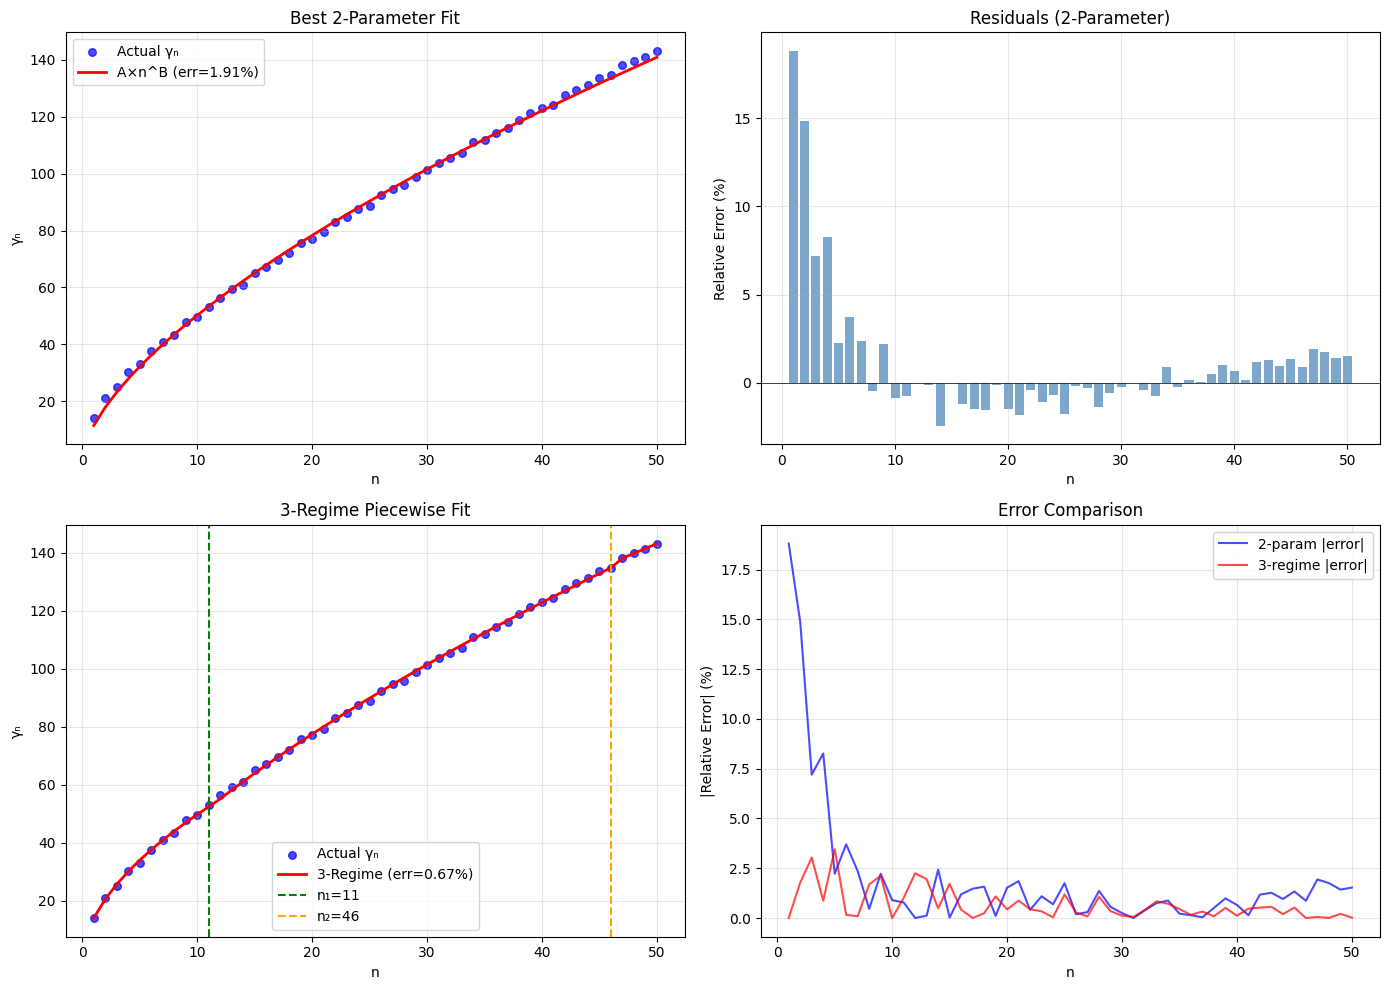


✓ Figure saved to gift_riemann_exploration.png


In [12]:
# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Best 2-param fit
ax1 = axes[0, 0]
n_plot = np.arange(1, 51)
pred_2p = result_2p.x[0] * n_plot**result_2p.x[1]
ax1.scatter(n_plot, gamma_50, c='blue', s=30, label='Actual γₙ', alpha=0.7)
ax1.plot(n_plot, pred_2p, 'r-', lw=2, label=f'A×n^B (err={result_2p.fun:.2f}%)')
ax1.set_xlabel('n')
ax1.set_ylabel('γₙ')
ax1.set_title('Best 2-Parameter Fit')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals
ax2 = axes[0, 1]
residuals_2p = (gamma_50 - pred_2p) / gamma_50 * 100
ax2.bar(n_plot, residuals_2p, color='steelblue', alpha=0.7)
ax2.axhline(0, color='black', lw=0.5)
ax2.set_xlabel('n')
ax2.set_ylabel('Relative Error (%)')
ax2.set_title('Residuals (2-Parameter)')
ax2.grid(True, alpha=0.3)

# 3. 3-regime fit
ax3 = axes[1, 0]
pred_3r = np.zeros(50)
for i, ni in enumerate(n_plot):
    if ni <= n1_opt:
        pred_3r[i] = A1 * ni**B1
    elif ni <= n2_opt:
        pred_3r[i] = A2 * ni**B2
    else:
        pred_3r[i] = A3 * ni**B3

ax3.scatter(n_plot, gamma_50, c='blue', s=30, label='Actual γₙ', alpha=0.7)
ax3.plot(n_plot, pred_3r, 'r-', lw=2, label=f'3-Regime (err={result_3r.fun:.2f}%)')
ax3.axvline(n1_opt, color='green', ls='--', label=f'n₁={n1_opt}')
ax3.axvline(n2_opt, color='orange', ls='--', label=f'n₂={n2_opt}')
ax3.set_xlabel('n')
ax3.set_ylabel('γₙ')
ax3.set_title('3-Regime Piecewise Fit')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Comparison of residuals
ax4 = axes[1, 1]
residuals_3r = (gamma_50 - pred_3r) / gamma_50 * 100
ax4.plot(n_plot, np.abs(residuals_2p), 'b-', lw=1.5, label='2-param |error|', alpha=0.7)
ax4.plot(n_plot, np.abs(residuals_3r), 'r-', lw=1.5, label='3-regime |error|', alpha=0.7)
ax4.set_xlabel('n')
ax4.set_ylabel('|Relative Error| (%)')
ax4.set_title('Error Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gift_riemann_exploration.png', dpi=150)
plt.show()

print("\n✓ Figure saved to gift_riemann_exploration.png")